In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_similarity_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA, TruncatedSVD

from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm
from math import pi

from src.pre_processing import *

In [2]:
pd.set_option('display.max_columns', 999)

### Create subset and fill NaN's

In [3]:
subset = create_subset(public_df, cols_to_keep)

In [4]:
# fill with mode b/c of outliers (7.0 mode vs 7101 mean)
subset['responseLagSeconds'] = subset['responseLagSeconds'].fillna(subset['responseLagSeconds'].mode()[0])

# fill with 0's because categorical and we're dummifying trigger data anyways; and 0 is mode of workPilingUp

subset[['generalTrigger', 'specificTrigger', 'workPilingUp']] = subset[['generalTrigger', 'specificTrigger', 'workPilingUp']].fillna(0)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [5]:
# fill remaining null's with mean (dailyAlertNumber and tiredness) - they are close to the mode.

subset.fillna(subset.mean(), inplace=True)

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


### Dummify categoricals

In [6]:
subset.head()

,responseLagSeconds,dailyAlertNumber,tiredness,feelingEmotion,generalEmotion,specificEmotion,intensity,generalTrigger,specificTrigger,bodySensationIntensity,bodySensationForehead,bodySensationEyes,bodySensationJaw,bodySensationNeck,bodySensationShoulders,bodySensationChest,bodySensationArms,bodySensationHands,bodySensationStomach,bodySensationBowel,bodySensationLegs,bodySensationFeet,bodySensationLowerBack,bodySensationUpperBack,bodySensationOther,bodySensationOtherLocation,emotionDuration,selfCareEatingWell,selfCareCooking,selfCareExercise,selfCareSeekingSupport,selfCareTimeOutside,selfCareSpiritualPractice,selfCareQualityTimeTogether,selfCareQualityTimeAlone,selfCarePet,selfCareOther,selfCareNone,selfCareOtherActivity,workPilingUp
0,2044.0,2.0,0.500000,1,enjoyment,peaceful,0.50,wellbeing,exercise,0.75,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,60,0,0,0,0,0,0,0,0,0,0,0,0,0.0
1,7642.0,2.0,0.465404,1,fear,anxious,0.25,workStress,workload,0.50,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,90,0,0,0,0,0,0,0,0,0,0,0,0,0.0
2,1330.0,4.0,0.465404,1,anger,frustrated,0.25,socialStress,soChallenge,0.25,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0.0
3,73.0,1.0,0.465404,1,enjoyment,happy,0.50,socialSupport,timeFamily,0.50,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0.0
4,56.0,2.0,0.465404,1,enjoyment,happy,0.50,wellbeing,play,0.50,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0.0


In [7]:
for col in cols_to_dummify:
    dummify_clustering(subset, col)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [8]:
subset.head()

,responseLagSeconds,dailyAlertNumber,tiredness,feelingEmotion,intensity,bodySensationIntensity,bodySensationForehead,bodySensationEyes,bodySensationJaw,bodySensationNeck,bodySensationShoulders,bodySensationChest,bodySensationArms,bodySensationHands,bodySensationStomach,bodySensationBowel,bodySensationLegs,bodySensationFeet,bodySensationLowerBack,bodySensationUpperBack,bodySensationOther,bodySensationOtherLocation,emotionDuration,selfCareEatingWell,selfCareCooking,selfCareExercise,selfCareSeekingSupport,selfCareTimeOutside,selfCareSpiritualPractice,selfCareQualityTimeTogether,selfCareQualityTimeAlone,selfCarePet,selfCareOther,selfCareNone,selfCareOtherActivity,workPilingUp,anger,enjoyment,fear,other,sadness,afraid,angry,annoyed,anxious,ashamed,discouraged,embarrassed,enthusiastic,excited,frustrated,happy,irritated,joyful,lonely,nervous,notListed,peaceful,sad,worried,0,personalConcerns,socialStress,socialSupport,wellbeing,workSatisfaction,workStress,world,bodyImage,clientChallenge,clientEnjoyable,climateChange,colleagueChallenge,colleagueEnjoyable,dislikeJob,domesticPolitics,exercise,familyChallenge,financialStress,friendsChallenge,globalPolitics,healthProblems,healthcare,lackMotivation,paperwork,patientChallenge,patientEnjoyable,play,productivity,relaxation,sleepDeprived,soChallenge,spiritual,success,timeFamily,timeFriends,timeSO,workload
0,2044.0,2.0,0.500000,1,0.50,0.75,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,60,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7642.0,2.0,0.465404,1,0.25,0.50,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,90,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1330.0,4.0,0.465404,1,0.25,0.25,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,73.0,1.0,0.465404,1,0.50,0.50,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,56.0,2.0,0.465404,1,0.50,0.50,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


### Scale data and PCA

In [9]:
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(subset)
scaled_subset = scaler.transform(subset)


In [10]:
scaled_subset

array([[0.18360191, 0.25      , 0.5       , ..., 0.        , 0.        ,
        0.        ],
       [0.18409864, 0.25      , 0.46540388, ..., 0.        , 0.        ,
        1.        ],
       [0.18353855, 0.75      , 0.46540388, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.18449164, 0.        , 0.5       , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.75      , 0.5       , ..., 0.        , 0.        ,
        1.        ],
       [0.18342116, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ]])

In [110]:
svd = TruncatedSVD(n_components=10, n_iter=7)
X_svd = svd.fit_transform(scaled_subset)

In [111]:
svd.singular_values_

array([129.61289475,  67.46710749,  45.19613332,  43.08881899,
        39.94621585,  38.44074148,  34.93315658,  33.75559749,
        32.89172939,  29.5360745 ])

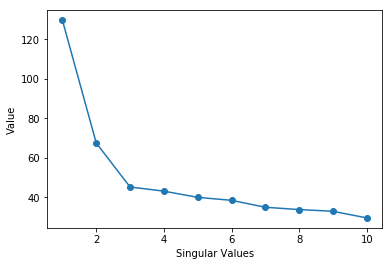

In [112]:
s = svd.singular_values_

x = [i+1 for i in range(len(s))]
plt.plot(x, s, marker='o')
plt.xlabel("Singular Values")
plt.ylabel("Value");

### kMeans Model after PCA

In [113]:
kmeans = KMeans(n_clusters=6)
predictions = kmeans.fit_predict(X_svd)
predictions

array([3, 4, 0, ..., 1, 5, 1], dtype=int32)

In [114]:
np.unique(predictions, return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=int32),
 array([1235, 1011,  854, 1850, 1408, 1068]))

In [115]:
np.unique(predictions == 1, return_counts=True)[1][1]

1011

In [116]:
silhouette_score(X_svd, predictions, metric='euclidean')

0.3286472775661901

### Plot Silhouettes

In [117]:
X = X_svd
range_n_clusters = range(2,10)

# taken from sklearn
def plot_silhouette(X):
    
    for n_clusters in range_n_clusters:
        fig, (ax1) = plt.subplots(1)
        fig.set_size_inches(18, 7)

        ax1.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
        silhouette_avg = silhouette_score(X, cluster_labels, metric='euclidean')
        print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

        plt.show()

For n_clusters = 2 The average silhouette_score is : 0.23657016538474077


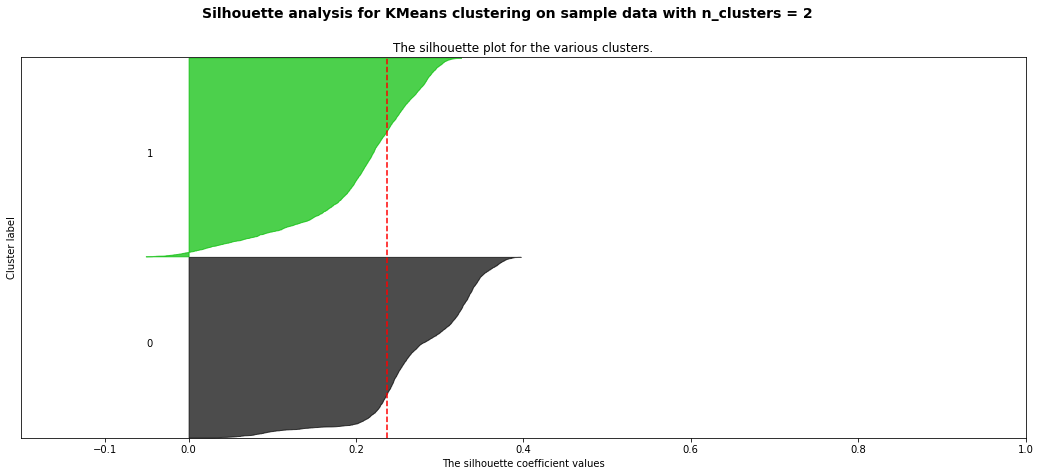

For n_clusters = 3 The average silhouette_score is : 0.2426366433870198


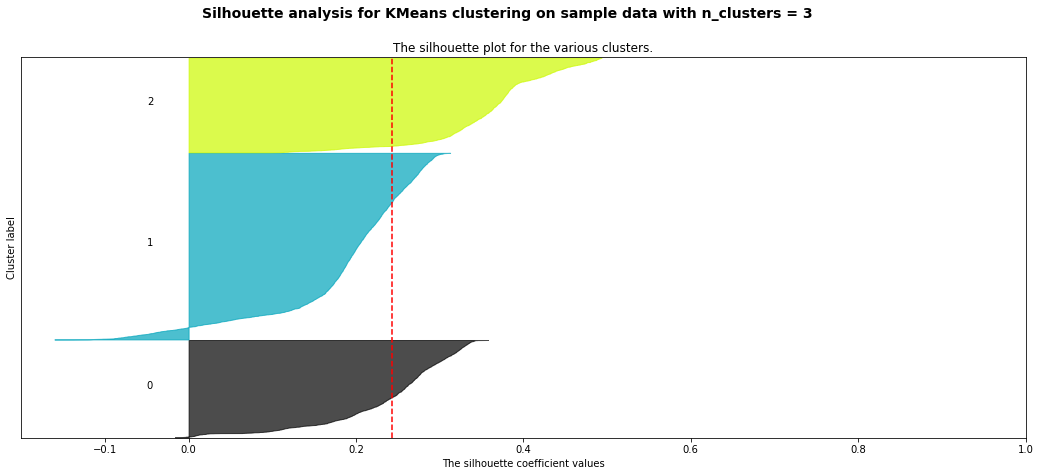

For n_clusters = 4 The average silhouette_score is : 0.26431572578659457


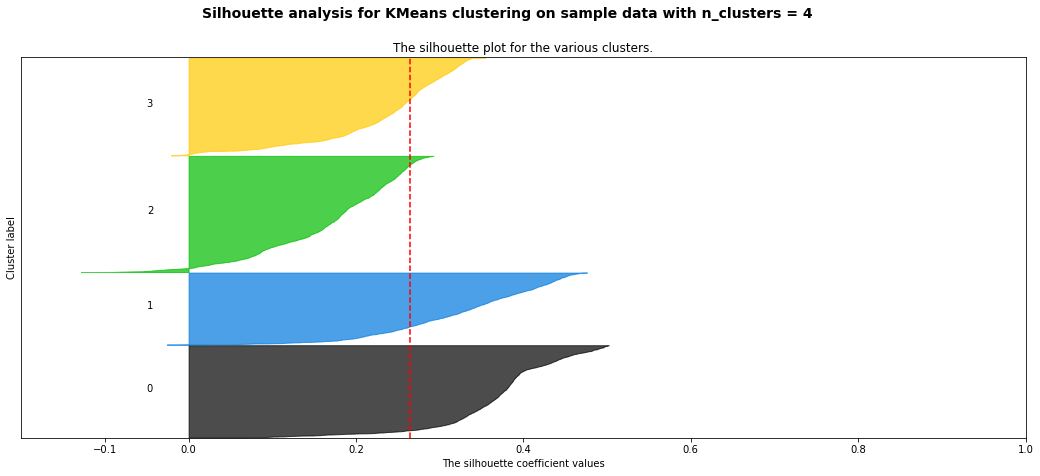

For n_clusters = 5 The average silhouette_score is : 0.30497604852672083


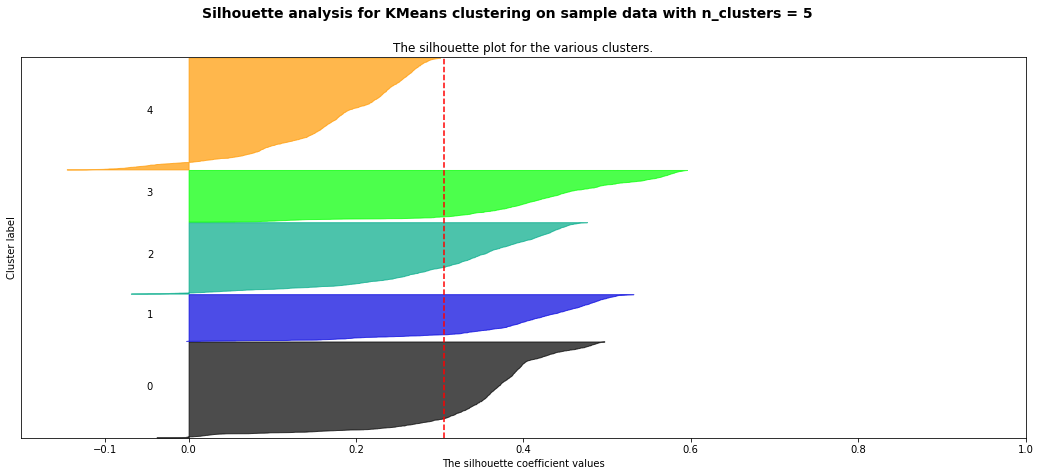

For n_clusters = 6 The average silhouette_score is : 0.3286472775661901


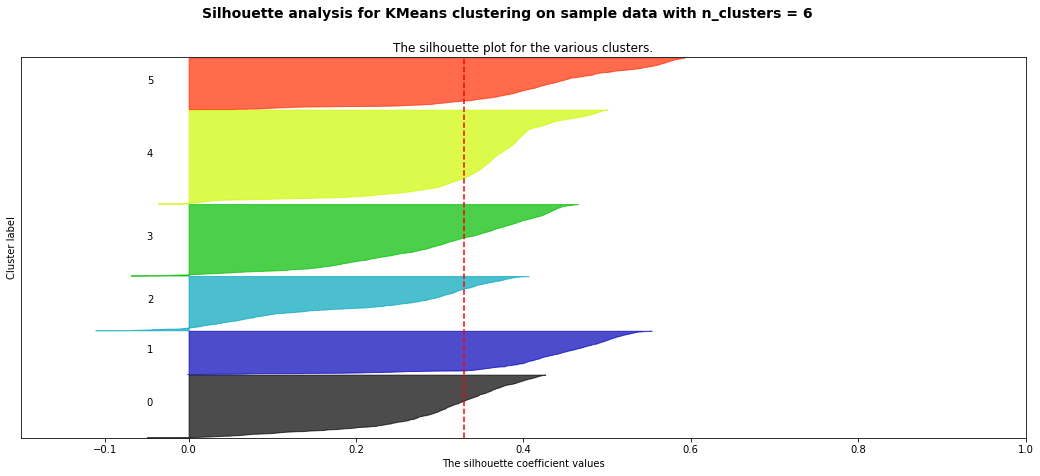

For n_clusters = 7 The average silhouette_score is : 0.32923494682545495


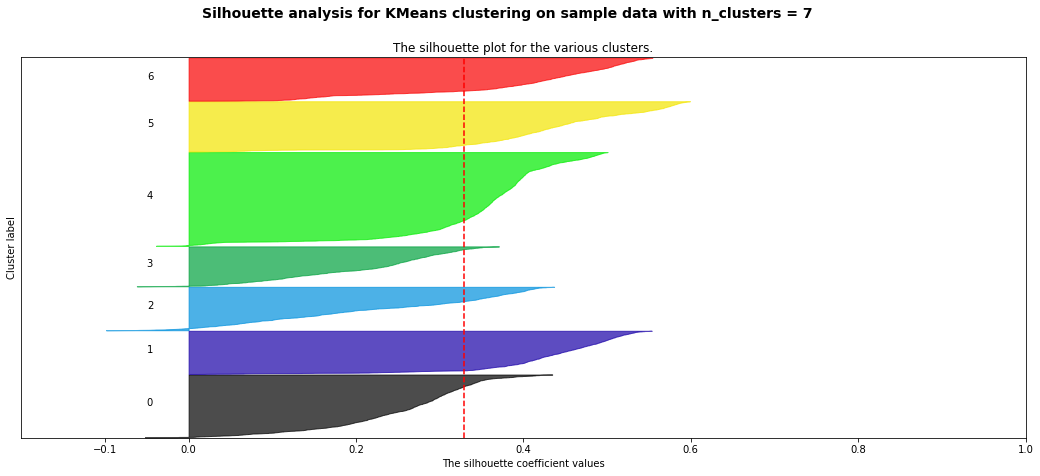

For n_clusters = 8 The average silhouette_score is : 0.3238811624283913


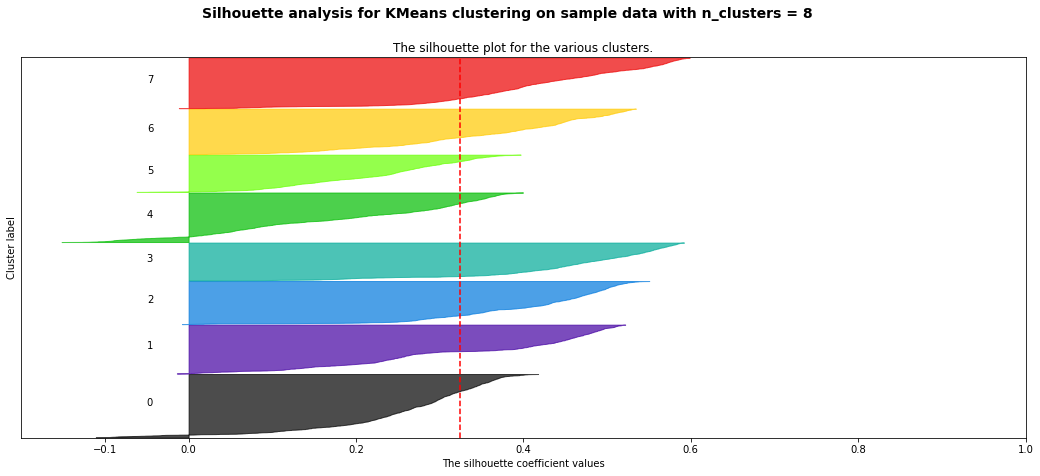

For n_clusters = 9 The average silhouette_score is : 0.33530315380696507


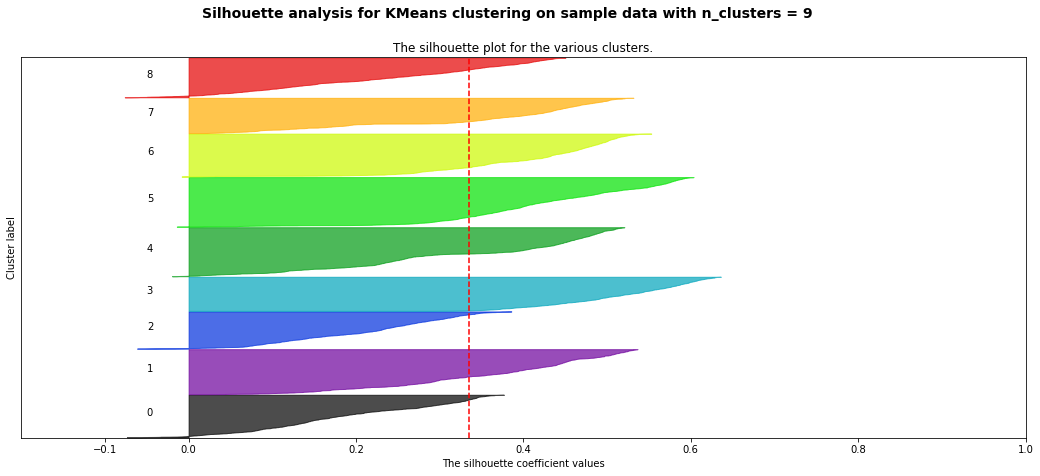

In [118]:
plot_silhouette(X)

### Check key features and add labels to dataframe

In [119]:
centroids = svd.inverse_transform(kmeans.cluster_centers_)
centroids[0]

array([ 1.78998936e-01,  2.76357642e-01,  4.35821802e-01,  6.96994471e-01,
        5.51154969e-01,  4.51165604e-01,  4.11326948e-02,  4.02951356e-02,
        2.92246522e-02,  5.20925111e-02,  5.14890600e-02,  3.58144453e-02,
        3.25423462e-03,  2.20243053e-03,  2.15103034e-02,  2.26755641e-03,
        3.80485185e-03,  1.86809816e-03,  6.46710866e-03,  6.95774090e-03,
        7.95129754e-03,  8.14543588e-03,  3.34126324e-01,  1.43434436e-02,
        1.15367905e-02,  1.22686854e-02,  3.37274455e-03,  1.47412883e-02,
        5.14544856e-03,  2.29817381e-02,  1.22210910e-02,  8.08785286e-03,
        3.14930407e-03,  2.08929179e-02,  0.00000000e+00,  2.84747074e-01,
        9.55766622e-01, -1.70834235e-04, -2.20194776e-02,  3.84731542e-02,
       -3.95390629e-02,  4.32851015e-03,  1.22913047e-01,  2.58746540e-01,
       -3.38107417e-02,  8.22756975e-03, -2.03000774e-02,  4.97365751e-03,
        3.62083726e-03,  3.88460638e-03,  3.10436945e-01, -1.53351485e-02,
        2.63670090e-01,  

In [120]:
top_centroids = np.argsort(centroids)[:, -1:-11:-1]

In [121]:
top_centroids

array([[36,  3,  4,  5,  2, 66, 22, 50, 35,  1],
       [65, 37,  3,  2,  4, 88, 22,  5, 48, 93],
       [63, 37,  3,  4,  2, 22, 51, 94, 95,  1],
       [64, 37,  3,  4,  2, 87, 57, 22,  5, 89],
       [38,  3, 44, 22,  4,  5, 66,  2, 35, 97],
       [ 3, 22, 40,  4,  5, 62, 35, 66,  2, 46]])

In [124]:
for i in range(6):
    print ('Cluster', i+1, 'total: ', np.unique(predictions == i, return_counts=True)[1][1])
    print (subset[predictions == i].iloc[:, top_centroids[i]].columns)
    print ()

Cluster 1 total:  1235
Index(['anger', 'feelingEmotion', 'intensity', 'bodySensationIntensity',
       'tiredness', 'workStress', 'emotionDuration', 'frustrated',
       'workPilingUp', 'dailyAlertNumber'],
      dtype='object')

Cluster 2 total:  1011
Index(['workSatisfaction', 'enjoyment', 'feelingEmotion', 'tiredness',
       'intensity', 'productivity', 'emotionDuration',
       'bodySensationIntensity', 'enthusiastic', 'success'],
      dtype='object')

Cluster 3 total:  854
Index(['socialSupport', 'enjoyment', 'feelingEmotion', 'intensity',
       'tiredness', 'emotionDuration', 'happy', 'timeFamily', 'timeFriends',
       'dailyAlertNumber'],
      dtype='object')

Cluster 4 total:  1850
Index(['wellbeing', 'enjoyment', 'feelingEmotion', 'intensity', 'tiredness',
       'play', 'peaceful', 'emotionDuration', 'bodySensationIntensity',
       'relaxation'],
      dtype='object')

Cluster 5 total:  1408
Index(['fear', 'feelingEmotion', 'anxious', 'emotionDuration', 'intensity',
   

In [125]:
# for i in top_centroids:
subset[predictions == 0].iloc[:, top_centroids[0]].describe()

,anger,feelingEmotion,intensity,bodySensationIntensity,tiredness,workStress,frustrated,workPilingUp,dailyAlertNumber
count,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000
mean,0.995951,0.708502,0.525506,0.409514,0.421952,0.416194,0.312551,1.091498,2.085735
std,0.063525,0.454636,0.240621,0.316453,0.224348,0.493126,0.463721,1.252117,0.997521
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,0.000000,0.250000,0.000000,0.250000,0.000000,0.000000,0.000000,1.000000
50%,1.000000,1.000000,0.500000,0.500000,0.465404,0.000000,0.000000,1.000000,2.000000
75%,1.000000,1.000000,0.750000,0.750000,0.500000,1.000000,1.000000,2.000000,3.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,5.000000


In [126]:
subset[predictions == 1].iloc[:, top_centroids[1]].describe()

,workSatisfaction,enjoyment,feelingEmotion,tiredness,intensity,productivity,bodySensationIntensity,enthusiastic,success
count,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000
mean,0.950544,0.893175,0.734916,0.552598,0.528932,0.419387,0.323689,0.257171,0.230465
std,0.216925,0.309043,0.441596,0.221366,0.195472,0.493703,0.284083,0.437291,0.421339
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.465404,0.500000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,0.500000,0.500000,0.000000,0.250000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,0.750000,0.750000,1.000000,0.500000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [127]:
subset[predictions == 1].iloc[:, top_centroids[1]]['emotionDuration'].value_counts()

15    224
30    211
5     195
90    182
60    165
1      34
Name: emotionDuration, dtype: int64

In [128]:
subset[predictions == 2].iloc[:, top_centroids[2]].describe()

# tiredness is higher here! Though this is the wellbeing cluster for people who are feeling happy/peaceful/relaxed

,socialSupport,enjoyment,feelingEmotion,intensity,tiredness,happy,timeFamily,timeFriends,dailyAlertNumber
count,854.000000,854.000000,854.000000,854.000000,854.000000,854.000000,854.000000,854.000000,854.000000
mean,0.977752,0.940281,0.689696,0.555913,0.486010,0.398126,0.364169,0.366511,2.234056
std,0.147576,0.237104,0.462889,0.200797,0.215882,0.489799,0.481478,0.482134,0.977240
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,1.000000,0.000000,0.500000,0.250000,0.000000,0.000000,0.000000,2.000000
50%,1.000000,1.000000,1.000000,0.500000,0.500000,0.000000,0.000000,0.000000,2.000000
75%,1.000000,1.000000,1.000000,0.750000,0.500000,1.000000,1.000000,1.000000,3.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000


In [129]:
subset[predictions == 3].iloc[:, top_centroids[3]].describe()

,wellbeing,enjoyment,feelingEmotion,intensity,tiredness,play,peaceful,bodySensationIntensity,relaxation
count,1850.000000,1850.000000,1850.000000,1850.000000,1850.000000,1850.000000,1850.000000,1850.000000,1850.000000
mean,0.956757,0.925946,0.672973,0.550946,0.515019,0.483784,0.476757,0.316486,0.301081
std,0.203459,0.261930,0.469254,0.199900,0.238130,0.499872,0.499595,0.298452,0.458852
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.500000,0.250000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,0.500000,0.500000,0.000000,0.000000,0.250000,0.000000
75%,1.000000,1.000000,1.000000,0.750000,0.750000,1.000000,1.000000,0.500000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [130]:
subset[predictions == 4].iloc[:, top_centroids[4]].describe()

,fear,feelingEmotion,anxious,intensity,bodySensationIntensity,workStress,tiredness,workPilingUp,workload
count,1408.00000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000
mean,0.99929,0.746449,0.530540,0.503374,0.462713,0.480824,0.433667,1.242188,0.265625
std,0.02665,0.435198,0.499244,0.234007,0.291788,0.499810,0.224228,1.280884,0.441822
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.00000,0.000000,0.000000,0.250000,0.250000,0.000000,0.250000,0.000000,0.000000
50%,1.00000,1.000000,1.000000,0.500000,0.500000,0.000000,0.465404,1.000000,0.000000
75%,1.00000,1.000000,1.000000,0.750000,0.750000,1.000000,0.500000,2.000000,1.000000
max,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [131]:
subset[predictions == 5].iloc[:, top_centroids[5]].describe()

,feelingEmotion,sadness,intensity,bodySensationIntensity,socialStress,workPilingUp,workStress,tiredness,discouraged
count,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000
mean,0.715356,0.674157,0.546348,0.406835,0.352060,1.176966,0.321161,0.372529,0.273408
std,0.451456,0.468908,0.241211,0.313855,0.477836,1.302997,0.467141,0.211194,0.445917
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000
50%,1.000000,1.000000,0.500000,0.500000,0.000000,1.000000,0.000000,0.465404,0.000000
75%,1.000000,1.000000,0.750000,0.750000,1.000000,2.000000,1.000000,0.500000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000


In [33]:
subset['label'] = pd.Series(predictions, index=subset.index)

In [34]:
subset['label'].value_counts()

1    1850
3    1408
5    1235
0    1068
2    1011
4     854
Name: label, dtype: int64

### Scatter plots

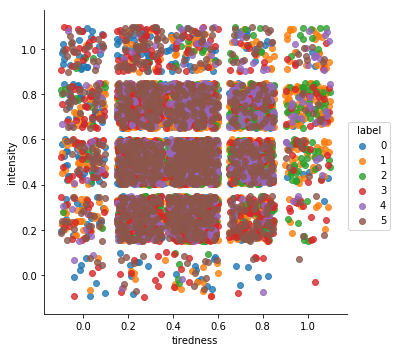

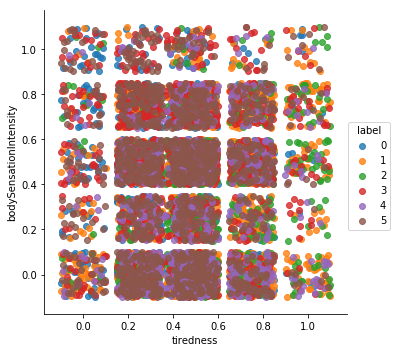

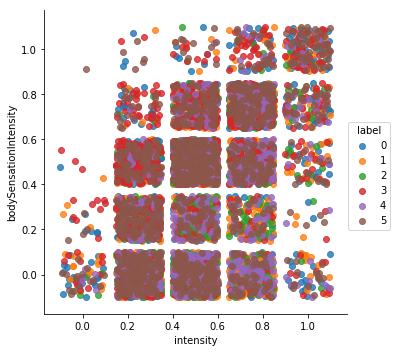

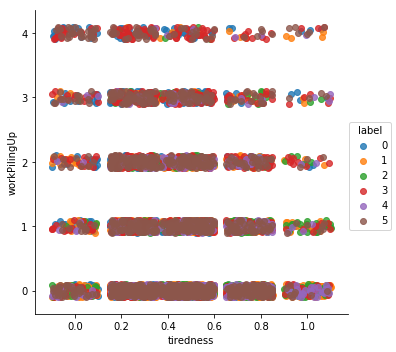

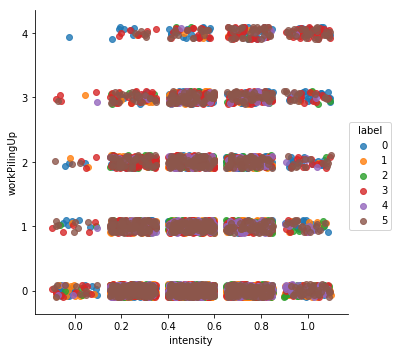

In [35]:
facet = sns.lmplot(data=subset, x='tiredness', y='intensity', hue='label', 
                   fit_reg=False, legend=True, legend_out=True, x_jitter=.1, y_jitter=0.1)
facet2 = sns.lmplot(data=subset, x='tiredness', y='bodySensationIntensity', hue='label', 
                   fit_reg=False, legend=True, legend_out=True, x_jitter=.1, y_jitter=0.1)
# facet3 = sns.lmplot(data=test_subset, x='tiredness', y='emotionDuration', hue='label', 
#                    fit_reg=False, legend=True, legend_out=True, x_jitter=0, y_jitter=0)
facet4 = sns.lmplot(data=subset, x='intensity', y='bodySensationIntensity', hue='label', 
                   fit_reg=False, legend=True, legend_out=True, x_jitter=.1, y_jitter=0.1)
facet5 = sns.lmplot(data=subset, x='tiredness', y='workPilingUp', hue='label', 
                   fit_reg=False, legend=True, legend_out=True, x_jitter=.1, y_jitter=.1)
facet6 = sns.lmplot(data=subset, x='intensity', y='workPilingUp', hue='label', 
                   fit_reg=False, legend=True, legend_out=True, x_jitter=.1, y_jitter=0.1)

### Swarm Plots

/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:2783: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


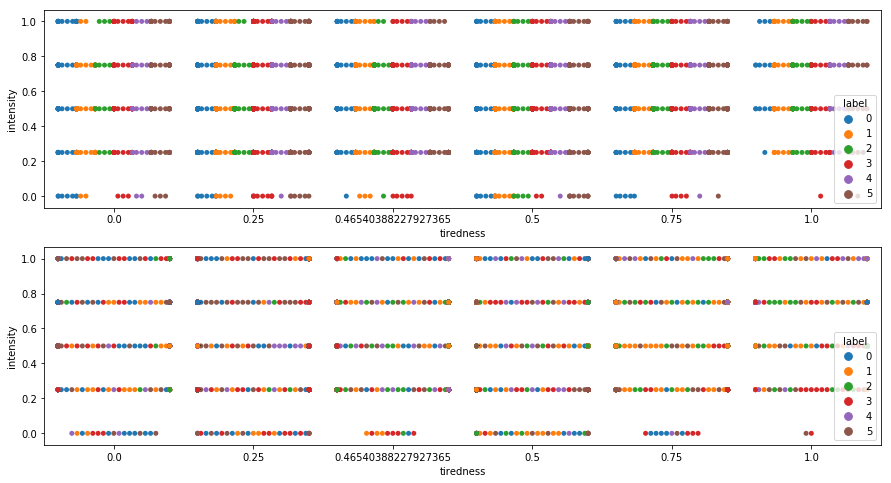

In [36]:
fig, ax = plt.subplots(2, 1, figsize=(15, 8))
# for i in range(6):
sns.swarmplot(x='tiredness', y='intensity', hue='label', split=True, data=subset, ax=ax[0]);
sns.swarmplot(x='tiredness', y='intensity', hue='label', data=subset, ax=ax[1]);

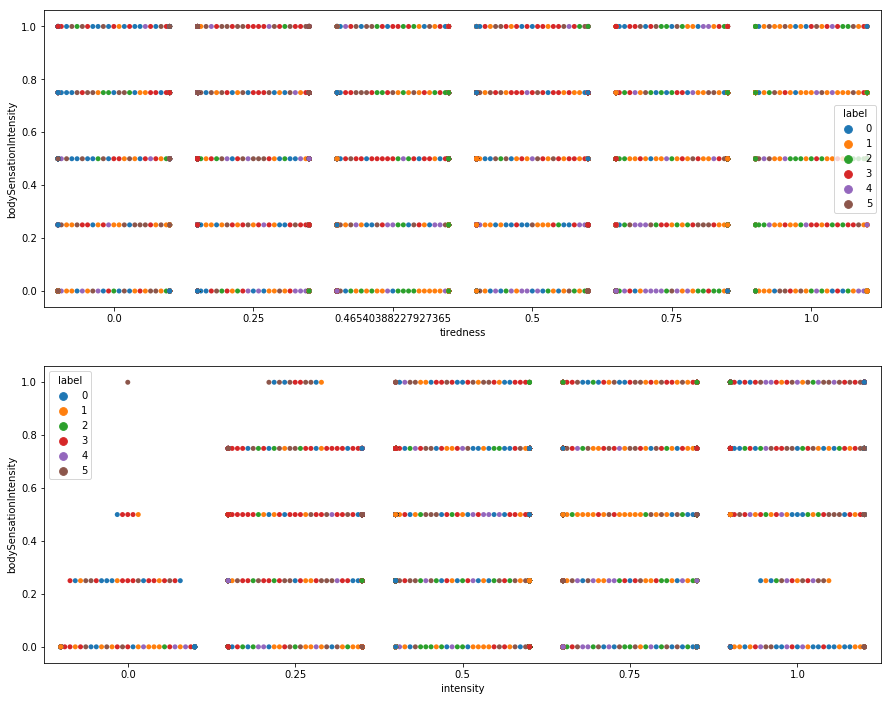

In [37]:
fig, ax = plt.subplots(2, 1, figsize=(15, 12))
# for i in range(6):
sns.swarmplot(x='tiredness', y='bodySensationIntensity', hue='label', data=subset, ax=ax[0]);
sns.swarmplot(x='intensity', y='bodySensationIntensity', hue='label', data=subset, ax=ax[1]);

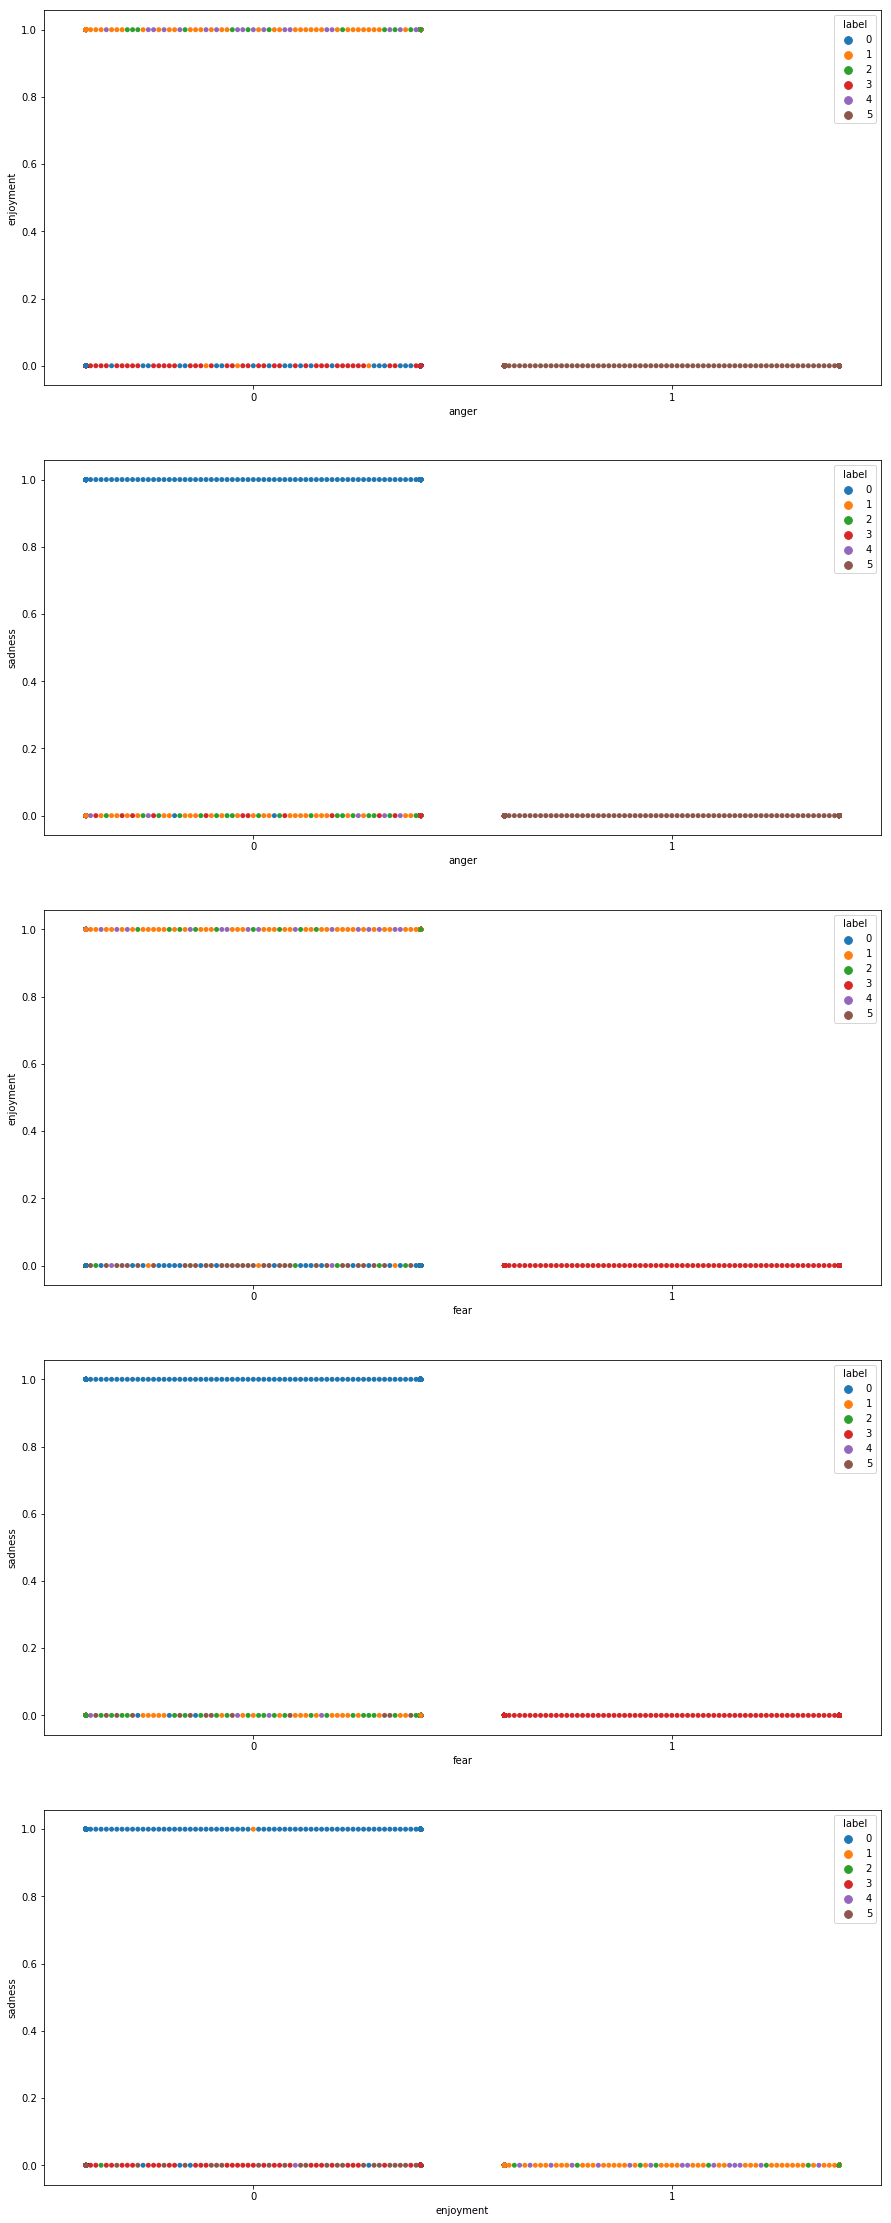

In [38]:
fig, ax = plt.subplots(5, 1, figsize=(15, 40))

emotions1 = ['anger', 'fear', 'enjoyment']
emotions2 = ['enjoyment', 'sadness']
num = 0

for e1 in emotions1:
    for e2 in emotions2:
        if e1 == e2:
            continue
        else:
            sns.swarmplot(x=e1, y=e2, hue='label', data=subset, ax=ax[num]);
            num += 1

# for i in range(6):
#     sns.swarmplot(x='intensity', y='bodySensationIntensity', data=test_subset[predictions == i], ax=ax[i]);

In [45]:
for num in range(6):
    print ('cluster', num, 'count:', (subset[subset['label'] == num]).shape)
    


cluster 0 count: (1068, 99)
cluster 1 count: (1850, 99)
cluster 2 count: (1011, 99)
cluster 3 count: (1408, 99)
cluster 4 count: (854, 99)
cluster 5 count: (1235, 99)


In [47]:
subset[predictions == 0].iloc[:, top_centroids[0]].describe()

,feelingEmotion,sadness,intensity,bodySensationIntensity,socialStress,workPilingUp,workStress,tiredness,discouraged
count,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000
mean,0.715356,0.674157,0.546348,0.406835,0.352060,1.176966,0.321161,0.372529,0.273408
std,0.451456,0.468908,0.241211,0.313855,0.477836,1.302997,0.467141,0.211194,0.445917
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000
50%,1.000000,1.000000,0.500000,0.500000,0.000000,1.000000,0.000000,0.465404,0.000000
75%,1.000000,1.000000,0.750000,0.750000,1.000000,2.000000,1.000000,0.500000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000


### Radar Charts

In [265]:
# col_list must begin with 'label' category to define clusters

def prep_for_radar(df, col_list):
    df = df[col_list]
    clusters = df.iloc[:, 0].values
    df.drop(['label'], axis=1, inplace=True)
    return df, clusters

In [279]:
cols = ['label', 'anger', 'enjoyment', 'sadness', 'fear', 'intensity']
cols2 = ['label', 'intensity', 'emotionDuration', 'sadness', 'fear', 'enjoyment', 'anger']
cols3 = ['label', 'intensity', 'emotionDuration', 'bodySensationIntensity', 'sadness', 'fear', 'enjoyment', 'anger']
cols4 = ['label', 'tiredness', 'intensity', 'emotionDuration', 'bodySensationIntensity', 'workPilingUp']

In [280]:
df, clusters = prep_for_radar(subset, cols)
df1, clusters1 = prep_for_radar(subset, cols2)
df2, clusters2 = prep_for_radar(subset, cols3)
df3, clusters3 = prep_for_radar(subset, cols4)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [268]:
scaler_radar = StandardScaler()
scaler.fit(df)
X = scaler.transform(df)
scaler.fit(df1)
X1 = scaler.transform(df1)
scaler.fit(df2)
X2 = scaler.transform(df2)

In [281]:
scaler.fit(df3)
X3 = scaler.transform(df3)

In [283]:
np.unique(X3, return_counts=True)

(array([0.        , 0.04494382, 0.15730337, 0.25      , 0.3258427 ,
        0.46540388, 0.5       , 0.66292135, 0.75      , 1.        ]),
 array([7327, 1359, 1468, 6344, 1384, 1038, 8705,  991, 5315, 3199]))

In [172]:
clusters

array([0, 1, 5, ..., 3, 4, 3], dtype=int32)

In [264]:
# function to plot radar graph; modified slightly from Elliot's post (https://medium.com/@Saslow/high-dimensionality-visualization-in-python-65790a4b1719)

def plot_radar(df, X, clusters):
    # number of variable
    categories=list(df)
    N = len(categories)

    #Define the preset angles for your graph
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    #Get the mean values on all features from specific cluster
    values = X[clusters == 0].mean(axis = 0)

    #add value to the end so that the fill will work correctly
    values = np.append(values,values[:1])

    #create axis
    ax = plt.subplot(111, polar=True)

    # change the xticks and y ticks
    plt.xticks(angles[:-1], categories, color='grey', size=8)
    plt.yticks([2,4,6], ["2","4","6"], color="grey", size=7)
    ax.set_rlabel_position(0)

    #Plot the values
    ax.plot(angles, values, linewidth=1, linestyle='solid')

    # Fill area
    ax.fill(angles, values, alpha=0.2,label = 'Cluster 1')

    # Do it again for other clusters
    values = X[clusters == 1].mean(axis = 0)
    values = np.append(values,values[:1])
    ax.plot(angles, values, linewidth=1, linestyle='solid')
    ax.fill(angles, values, alpha=0.2,label = 'Cluster 2')

    # Do it again for other clusters
    values = X[clusters == 2].mean(axis = 0)
    values = np.append(values,values[:1])
    ax.plot(angles, values, linewidth=1, linestyle='solid')
    ax.fill(angles, values, alpha=0.2,label = 'Cluster 3')

    # Do it again for other clusters
    values = X[clusters == 3].mean(axis = 0)
    values = np.append(values,values[:1])
    ax.plot(angles, values, linewidth=1, linestyle='solid')
    ax.fill(angles, values, alpha=0.2,label = 'Cluster 4')

    # Do it again for other clusters
    values = X[clusters == 4].mean(axis = 0)
    values = np.append(values,values[:1])
    ax.plot(angles, values, linewidth=1, linestyle='solid')
    ax.fill(angles, values, alpha=0.2,label = 'Cluster 5')

    # And for the last cluster
    values = X[clusters == 5].mean(axis = 0)
    values = np.append(values,values[:1])
    ax.plot(angles, values, linewidth=1, linestyle='solid')
    ax.fill(angles, values, alpha=0.2,label = 'Cluster 6')

    plt.legend(bbox_to_anchor=(1, 1),
               bbox_transform=plt.gcf().transFigure)
    plt.title('Emotion Clusters on Radar Graph');
    plt.subplots_adjust(hspace=.8)

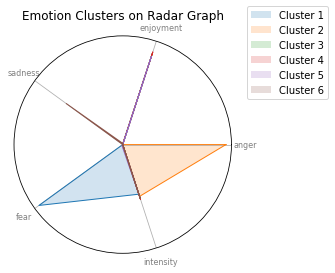

In [276]:
plot_radar(df, X, clusters)

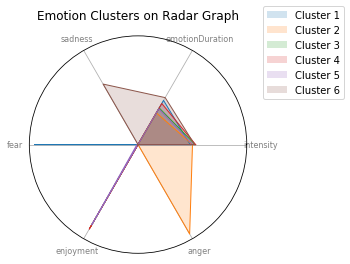

In [277]:
plot_radar(df1, X1, clusters1)

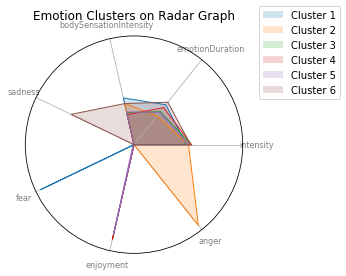

In [278]:
plot_radar(df2, X2, clusters2)